In [1]:
# !pip install xgboost
import sklearn
import numpy

In [2]:
numpy.__version__

'2.2.0'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
sp500 = pd.read_csv('../Data/sp500_main.csv')
macro = pd.read_csv('../Data/macro_data.csv')

In [5]:
macro= macro.set_index('Date')
sp500 = sp500.set_index('Date')

In [6]:
sp500

,AAPL,AMZN,AVGO,COST,GOOG,GOOGL,HD,JPM,LLY,MA,META,MSFT,NVDA,ORCL,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.234297,19.898500,3.961283,94.369179,27.624825,27.755241,63.568802,43.285351,40.585152,77.984024,54.545769,31.058565,0.373966,32.008656,58.940643,10.006667,63.013271,51.132057,21.054295,62.739441
2014-01-03,16.855730,19.822001,3.976331,93.952660,27.423307,27.552771,63.468048,43.619984,40.881153,77.672729,54.396221,30.849604,0.369486,31.923794,58.874783,9.970667,63.461128,51.166771,20.984922,62.588505
2014-01-06,16.947645,19.681499,3.949246,93.239731,27.729059,27.859968,62.855755,43.872814,41.225163,77.287491,57.028294,30.197683,0.374438,31.796507,59.013802,9.800000,62.734417,50.859058,20.867523,62.682835
2014-01-07,16.826441,19.901501,3.986865,92.807159,28.263626,28.397058,63.165791,43.367157,40.953148,78.364082,57.746128,30.431717,0.380568,32.118965,59.584633,9.957333,64.652641,51.247742,20.931564,63.569683
2014-01-08,16.933004,20.096001,4.046303,91.357330,28.322445,28.456152,63.499035,43.776134,40.889141,78.340698,58.055202,29.888441,0.385756,32.008652,58.721100,10.085333,63.900585,51.411995,20.766140,63.362122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-05,243.039993,220.550003,170.470001,982.260010,174.112473,172.442368,426.540009,245.479996,825.619995,524.770020,608.929993,442.619995,145.059998,186.240005,176.029999,369.489990,576.757812,309.079987,95.300003,114.779999
2024-12-06,242.839996,227.029999,179.529999,992.609985,176.290009,174.510010,431.369995,247.360001,826.710022,528.570007,623.770020,443.570007,142.440002,191.690002,173.820007,389.220001,547.519958,311.010010,95.699997,113.570000
2024-12-09,246.750000,226.089996,178.940002,987.859985,177.100006,175.369995,429.179993,243.809998,803.580017,522.820007,613.570007,446.019989,138.809998,190.449997,170.789993,389.790009,560.619995,308.299988,93.830002,112.900002


In [7]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in sp500.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = sp500[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = sp500[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = sp500[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = sp500[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = sp500[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = sp500[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = sp500[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = sp500[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, sp500], axis=1)

In [8]:
indicator = indicator.dropna()

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [10]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [11]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
sp500.index = pd.to_datetime(sp500.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = sp500.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
sp500 = sp500.loc[common_index]
features_df = features_df.loc[common_index]

In [12]:
features_df.shape, sp500.shape

((2556, 224), (2556, 20))

In [13]:
# define X and y
X = features_df 
y = sp500 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Training set shape for AAPL: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AAPL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\Denice\anaconda3\envs\py311_tf212\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for AAPL: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for AAPL - RMSE: 23.719824967067876


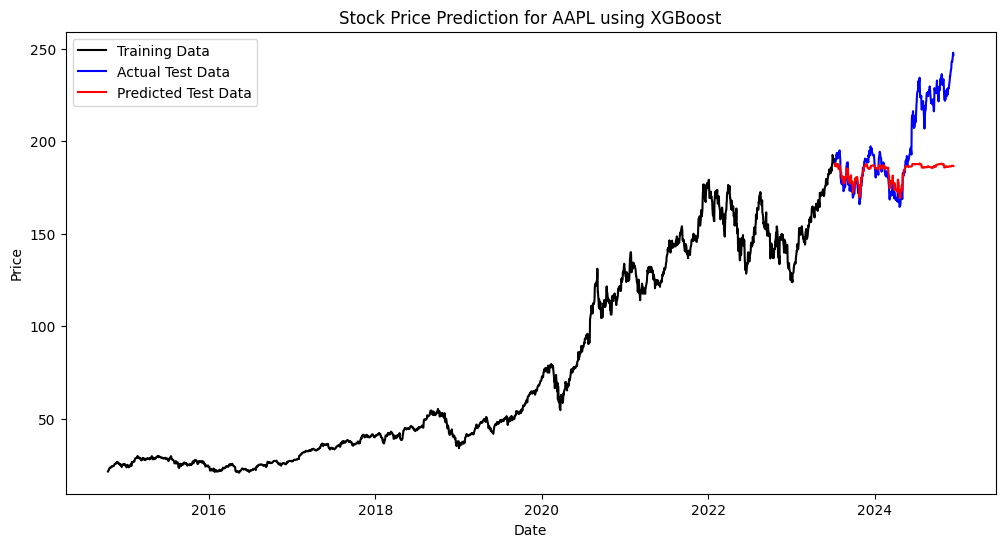

Training set shape for AMZN: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AMZN: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for AMZN: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Performance for AMZN - RMSE: 9.405250048078424


<Figure size 640x480 with 0 Axes>

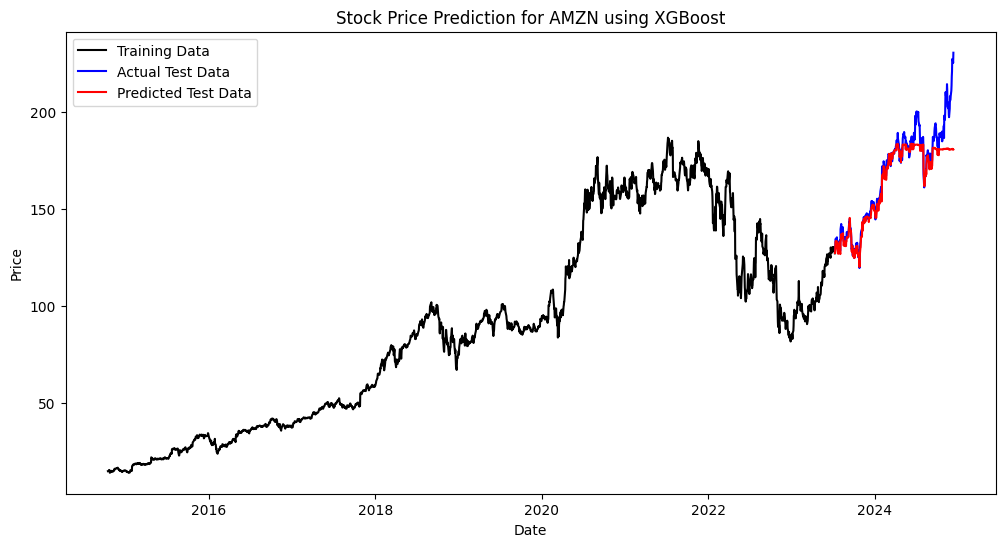

Training set shape for AVGO: X_train: (2196, 224), y_train: (2196,)
Testing set shape for AVGO: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for AVGO: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for AVGO - RMSE: 58.62410921743913


<Figure size 640x480 with 0 Axes>

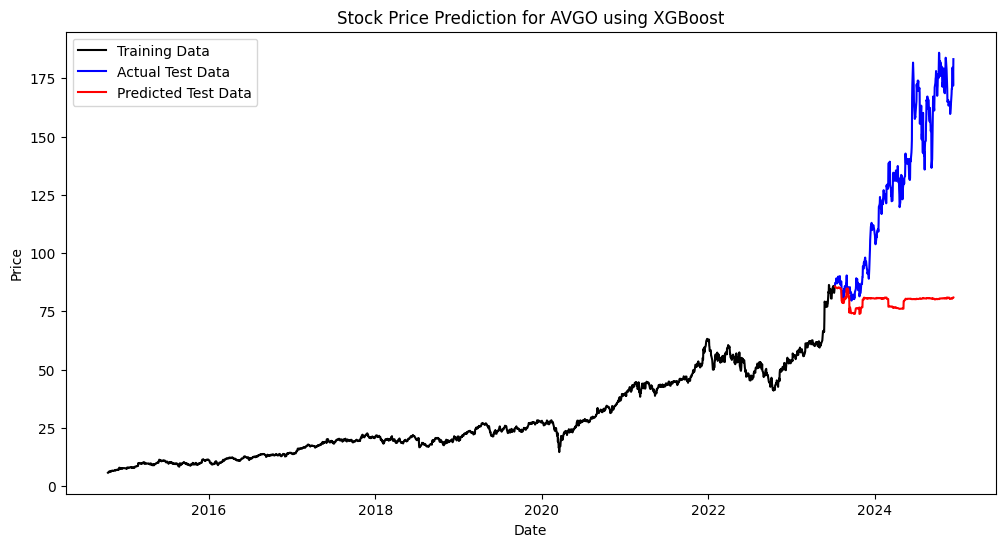

Training set shape for COST: X_train: (2196, 224), y_train: (2196,)
Testing set shape for COST: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for COST: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for COST - RMSE: 210.49507277485176


<Figure size 640x480 with 0 Axes>

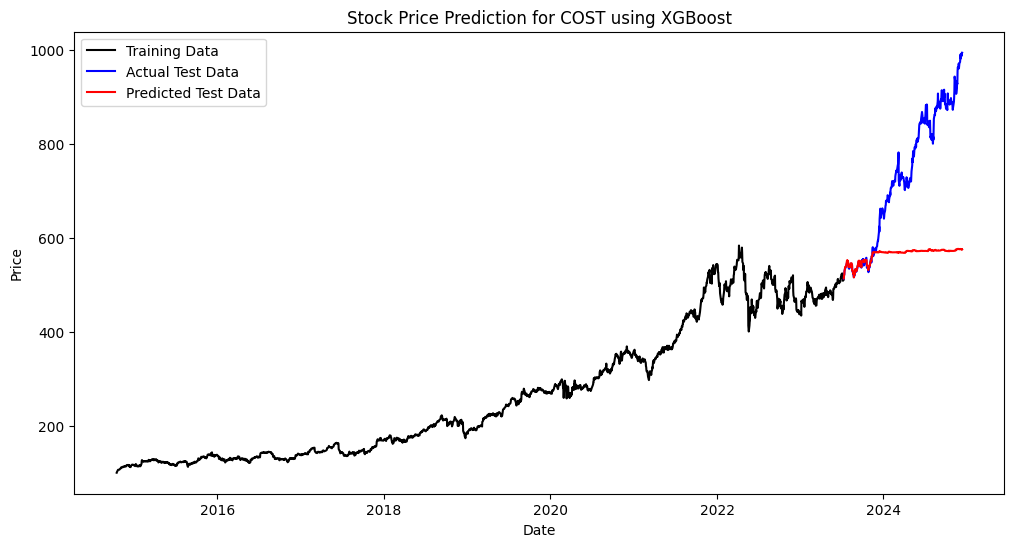

Training set shape for GOOG: X_train: (2196, 224), y_train: (2196,)
Testing set shape for GOOG: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for GOOG: {'alpha': 0, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Performance for GOOG - RMSE: 16.350662858745295


<Figure size 640x480 with 0 Axes>

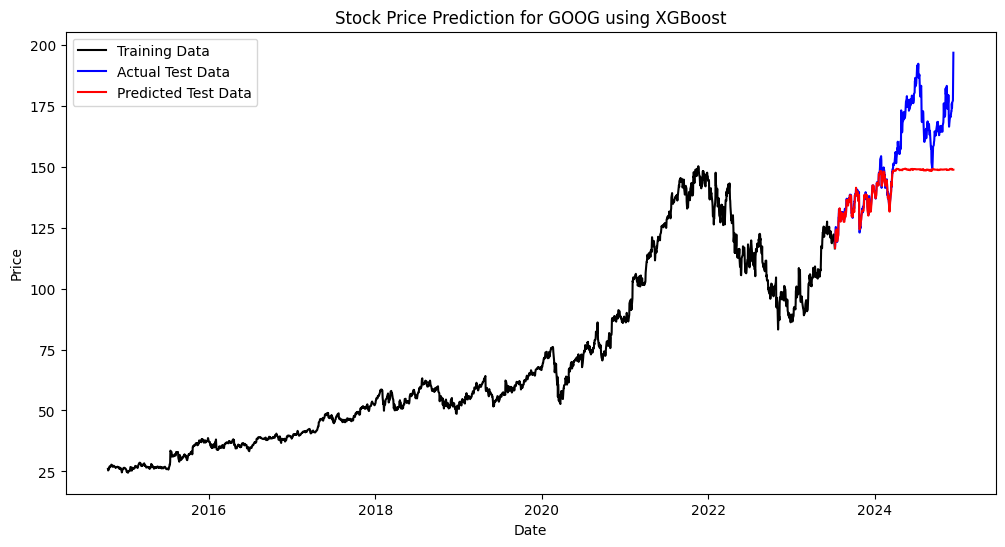

Training set shape for GOOGL: X_train: (2196, 224), y_train: (2196,)
Testing set shape for GOOGL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for GOOGL: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Performance for GOOGL - RMSE: 16.08846788711631


<Figure size 640x480 with 0 Axes>

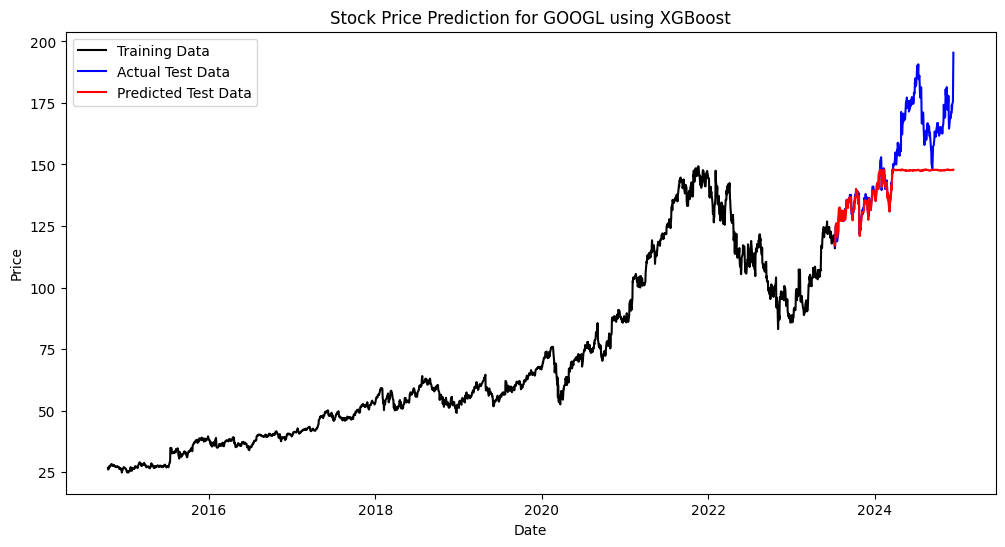

Training set shape for HD: X_train: (2196, 224), y_train: (2196,)
Testing set shape for HD: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for HD: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for HD - RMSE: 12.305320272356877


<Figure size 640x480 with 0 Axes>

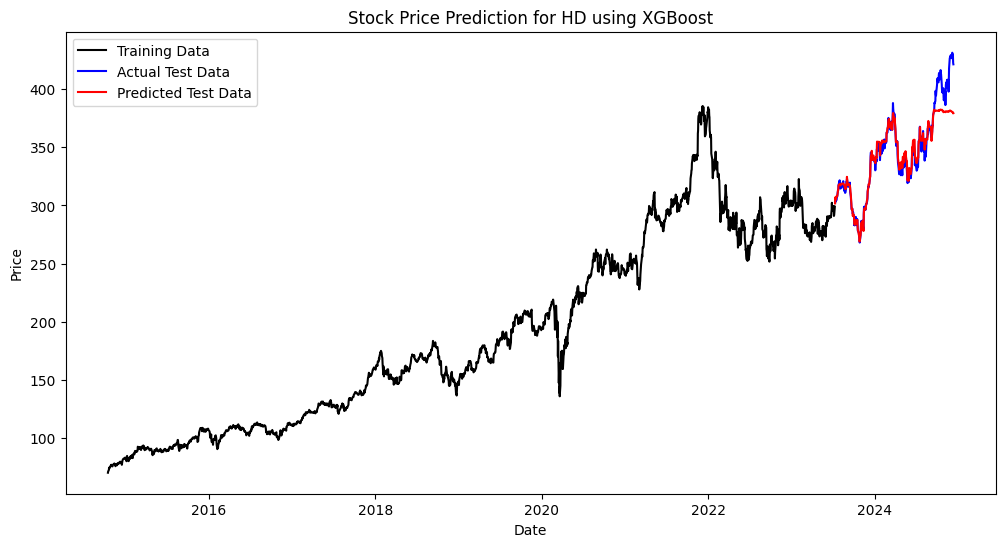

Training set shape for JPM: X_train: (2196, 224), y_train: (2196,)
Testing set shape for JPM: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for JPM: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for JPM - RMSE: 40.682809731051954


<Figure size 640x480 with 0 Axes>

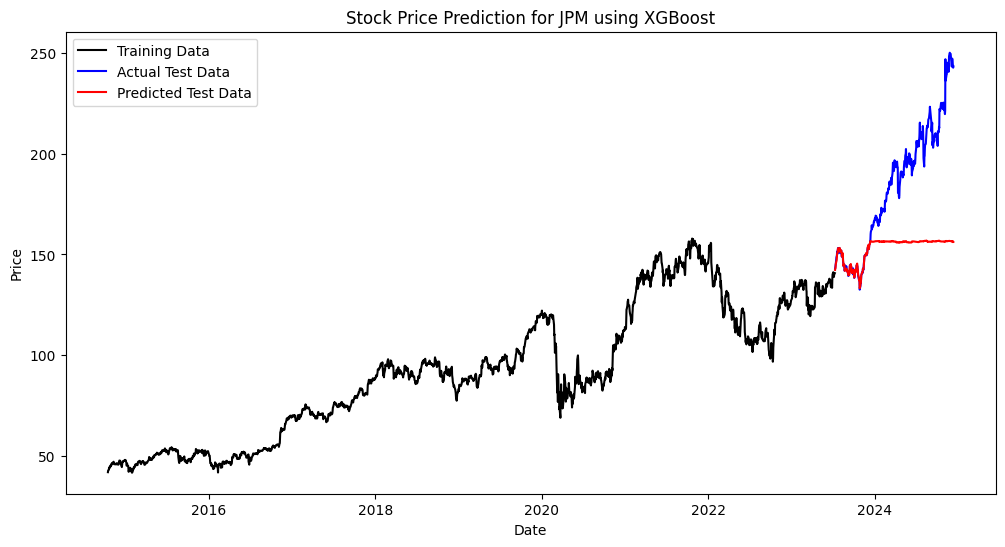

Training set shape for LLY: X_train: (2196, 224), y_train: (2196,)
Testing set shape for LLY: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for LLY: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for LLY - RMSE: 310.94669997974


<Figure size 640x480 with 0 Axes>

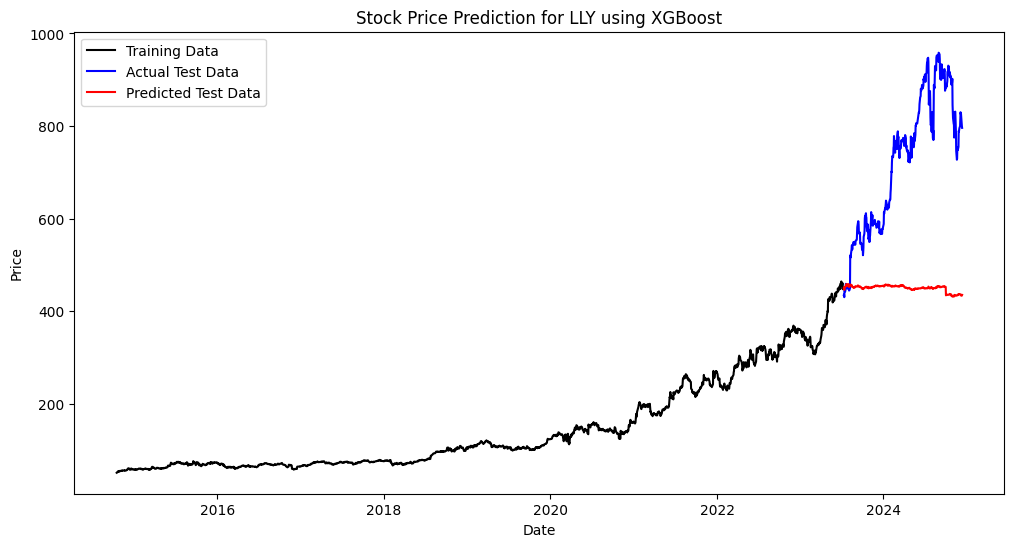

Training set shape for MA: X_train: (2196, 224), y_train: (2196,)
Testing set shape for MA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for MA: {'alpha': 10, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for MA - RMSE: 72.49920874266834


<Figure size 640x480 with 0 Axes>

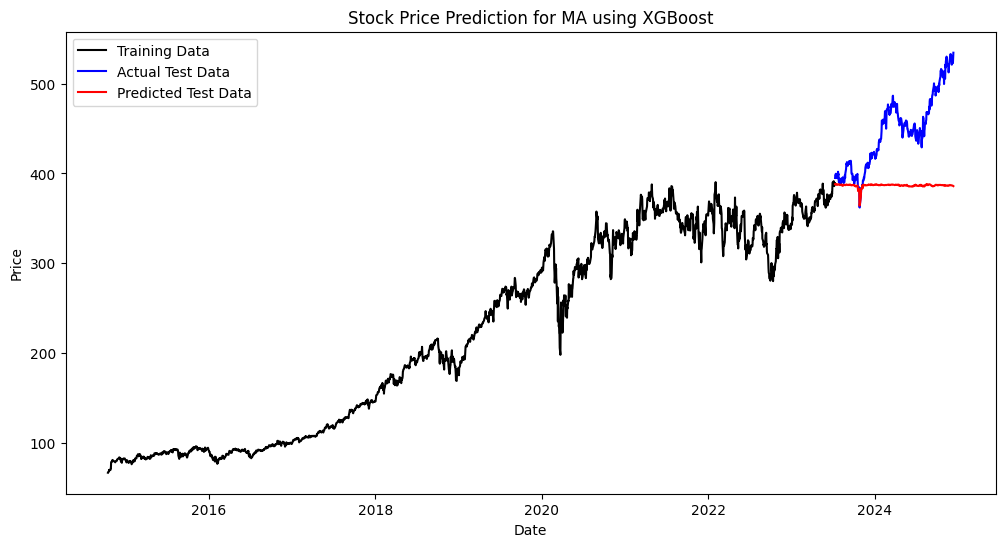

Training set shape for META: X_train: (2196, 224), y_train: (2196,)
Testing set shape for META: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for META: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Performance for META - RMSE: 116.09717797357335


<Figure size 640x480 with 0 Axes>

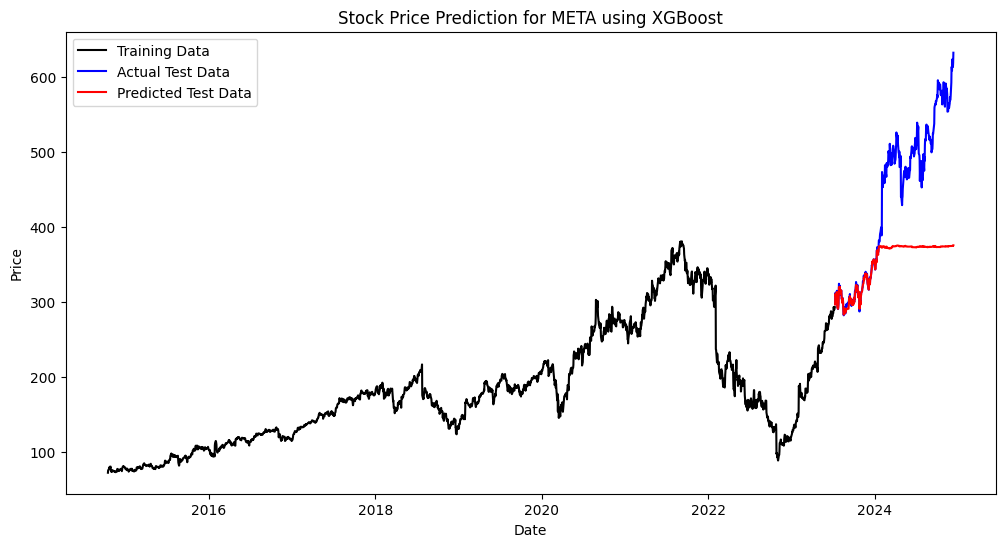

Training set shape for MSFT: X_train: (2196, 224), y_train: (2196,)
Testing set shape for MSFT: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for MSFT: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Performance for MSFT - RMSE: 70.32267787087213


<Figure size 640x480 with 0 Axes>

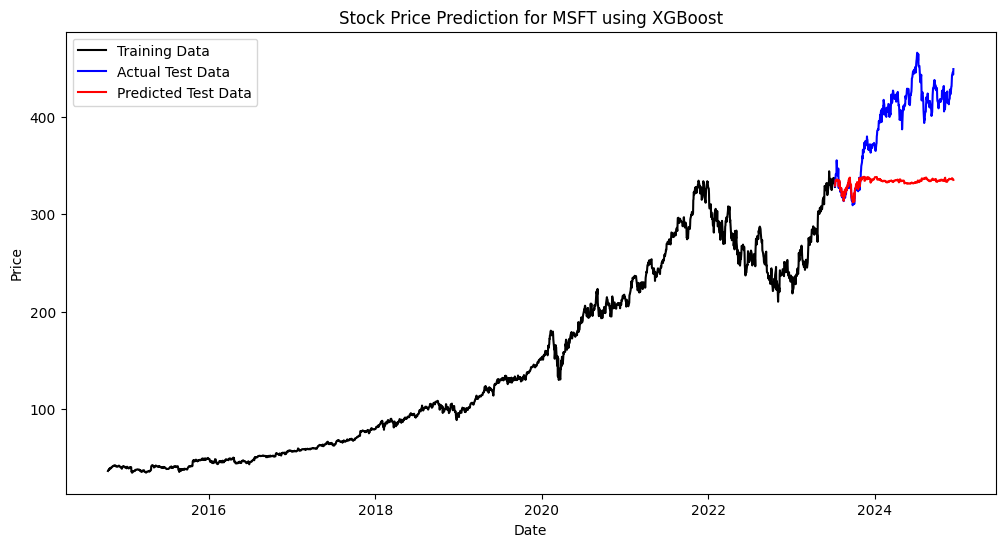

Training set shape for NVDA: X_train: (2196, 224), y_train: (2196,)
Testing set shape for NVDA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for NVDA: {'alpha': 0, 'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for NVDA - RMSE: 57.16887915610964


<Figure size 640x480 with 0 Axes>

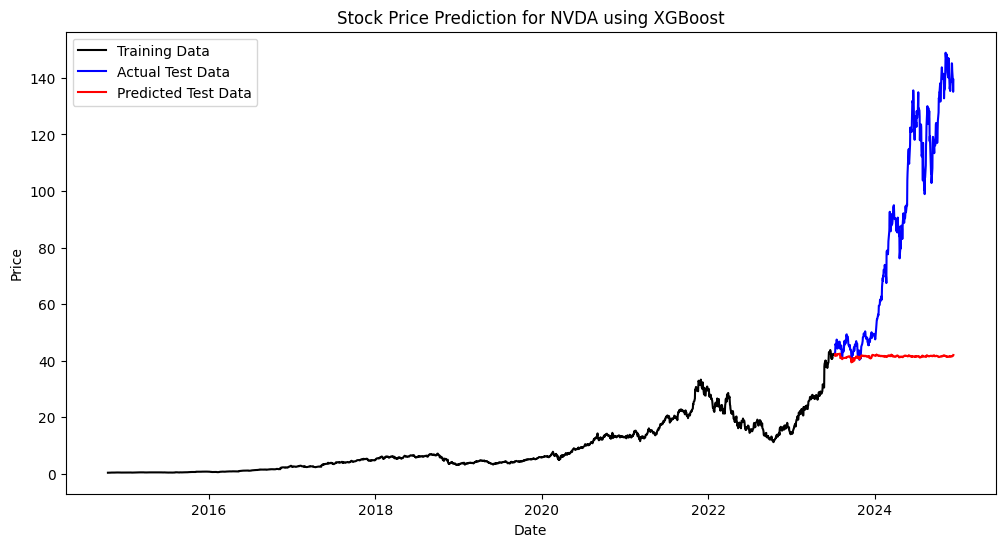

Training set shape for ORCL: X_train: (2196, 224), y_train: (2196,)
Testing set shape for ORCL: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for ORCL: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Performance for ORCL - RMSE: 29.308005427377033


<Figure size 640x480 with 0 Axes>

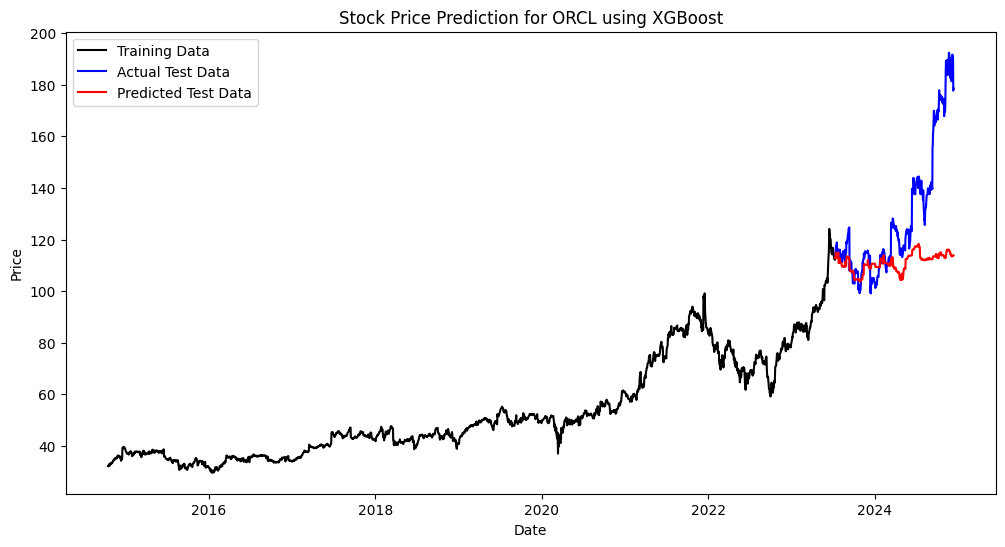

Training set shape for PG: X_train: (2196, 224), y_train: (2196,)
Testing set shape for PG: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for PG: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for PG - RMSE: 10.704005056119287


<Figure size 640x480 with 0 Axes>

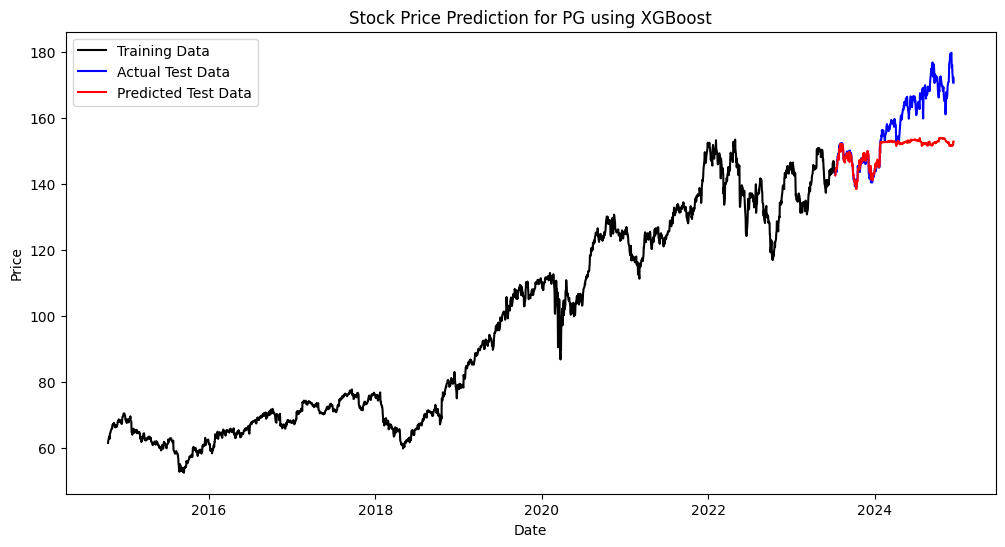

Training set shape for TSLA: X_train: (2196, 224), y_train: (2196,)
Testing set shape for TSLA: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for TSLA: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for TSLA - RMSE: 4.69892337972941


<Figure size 640x480 with 0 Axes>

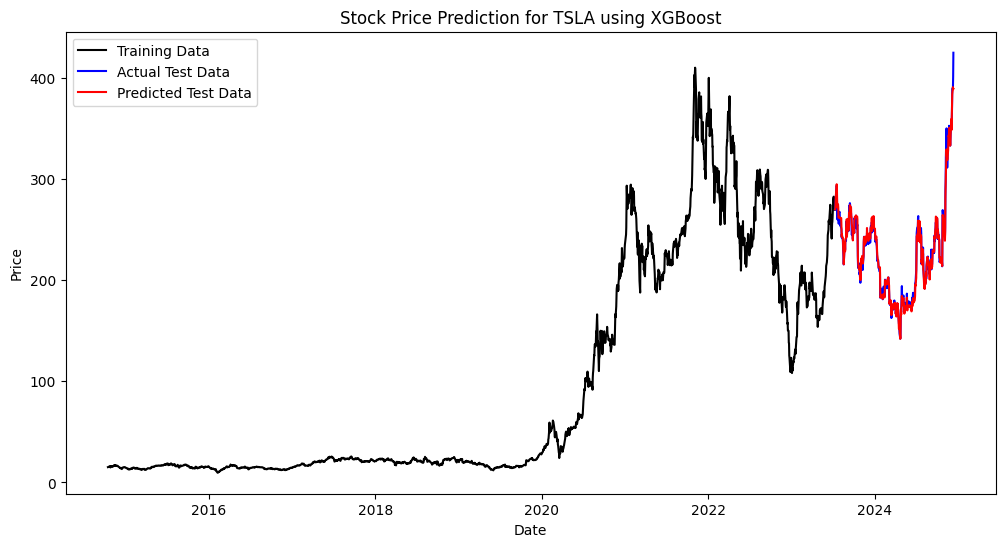

Training set shape for UNH: X_train: (2196, 224), y_train: (2196,)
Testing set shape for UNH: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for UNH: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Performance for UNH - RMSE: 27.96781859704282


<Figure size 640x480 with 0 Axes>

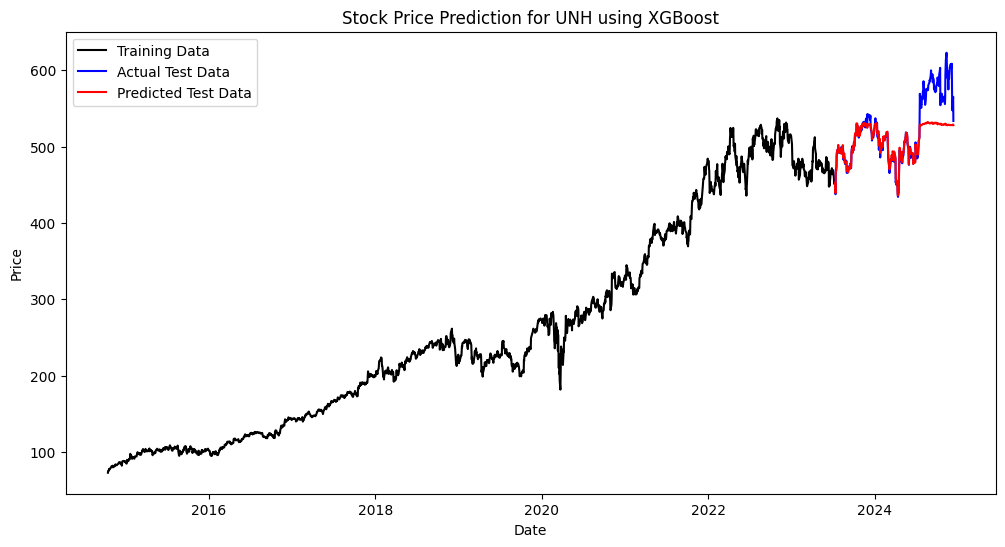

Training set shape for V: X_train: (2196, 224), y_train: (2196,)
Testing set shape for V: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for V: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for V - RMSE: 32.77766960942503


<Figure size 640x480 with 0 Axes>

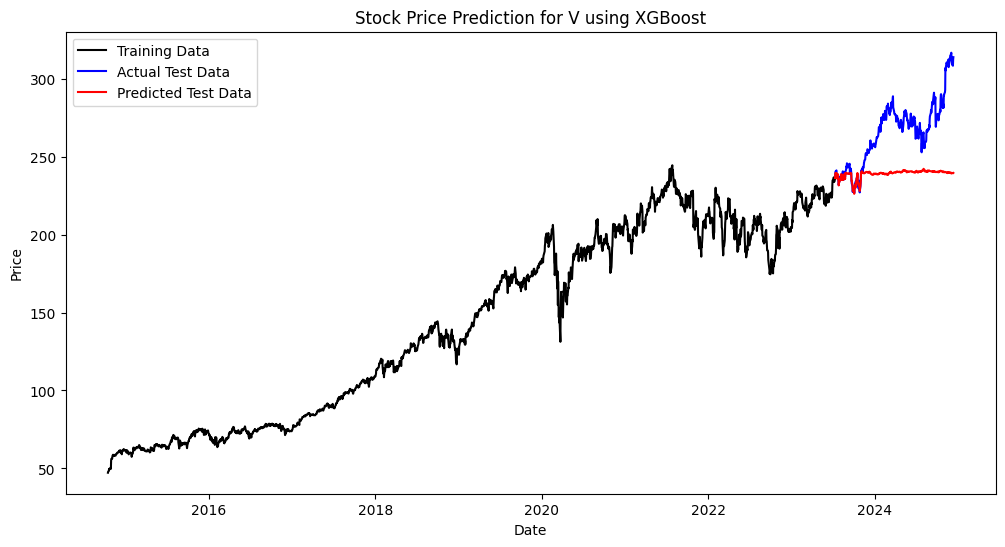

Training set shape for WMT: X_train: (2196, 224), y_train: (2196,)
Testing set shape for WMT: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for WMT: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for WMT - RMSE: 16.932985177359345


<Figure size 640x480 with 0 Axes>

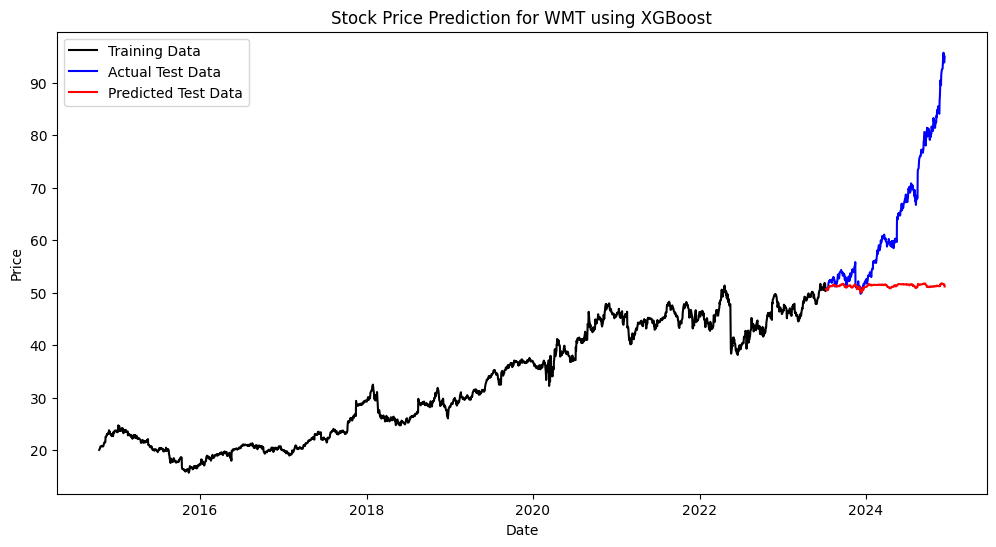

Training set shape for XOM: X_train: (2196, 224), y_train: (2196,)
Testing set shape for XOM: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Hyperparameters for XOM: {'alpha': 0, 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Performance for XOM - RMSE: 4.443442987828187


<Figure size 640x480 with 0 Axes>

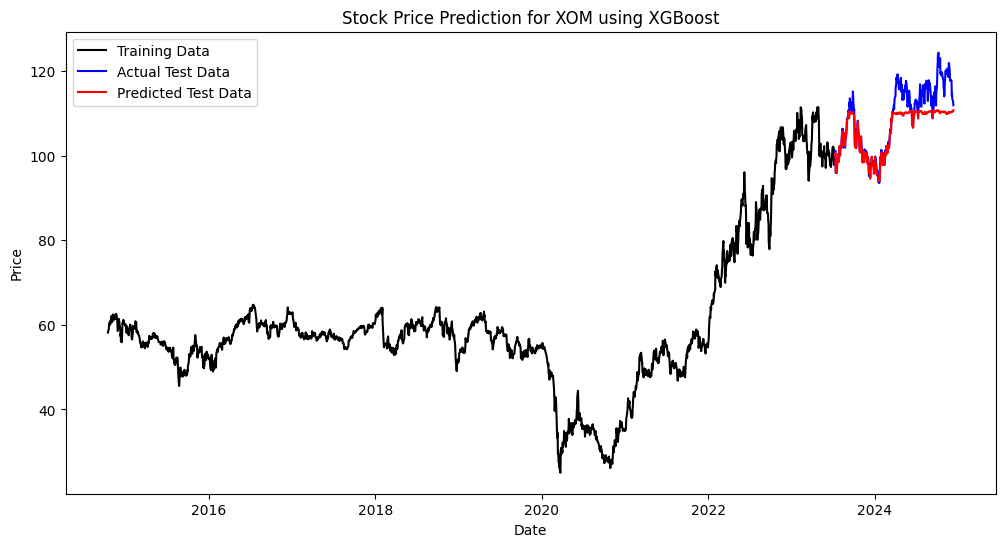

<Figure size 640x480 with 0 Axes>

In [14]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'colsample_bytree': [ 0.5, 0.7],
    'alpha': [0, 10]
}

# Fixed test size for the last 360 rows
test_size = 360

# Loop through each stock in the sp500 DataFrame
for stock in sp500.columns:
    
    # Prepare the target (stock price) for each stock
    y_stock = sp500[stock]  # Stock price for this particular stock
    
    # Define training and testing sets
    X_train = features_df.iloc[:-test_size, :]
    X_test = features_df.iloc[-test_size:, :]
    y_train = y_stock.iloc[:-test_size]
    y_test = y_stock.iloc[-test_size:]
    
    # Print dataset shapes
    print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Initialize the XGBoost regressor
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror',tree_method="hist", device="cuda")

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, 
                               cv=3, scoring='neg_mean_squared_error', verbose=1)
    
    # Fit the GridSearchCV model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters for {stock}: {best_params}")
    
    # Use the best estimator found by GridSearchCV to make predictions
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'Performance for {stock} - RMSE: {rmse}')
    
    # Store the results (model, predictions, evaluation metrics)
    results[stock] = {
        'model': best_model, 
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse
    }
    
    # Plot Actual vs Predicted Stock Prices
    # plt.figure(figsize=(12, 6))
    # plt.plot(y_test.index, y_test.values, color='blue', label='Actual Prices')
    # plt.plot(y_test.index, y_pred, color='red', label='Predicted Prices')
    # plt.title(f'Stock Price Prediction for {stock} using XGBoost')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.show()

    # Plot Actual vs Predicted Stock Prices
    plt.figure(figsize=(12, 6))
    plt.plot(y_stock.index[:-test_size], y_stock.values[:-test_size], color='black', label='Training Data')
    plt.plot(sp500[stock].index[-test_size:], sp500[stock].values[-test_size:], color='blue', label='Actual Test Data')
    plt.plot(sp500[stock].index[-test_size:], y_pred, color='red', label='Predicted Test Data')
    plt.title(f'Stock Price Prediction for {stock} using XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Save the plot
    plt.savefig(f'../images/{stock}_xgboost_prediction.png', format='png')
